In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bits_minuto = 90
pulses_number = 30
distance = 0.9
print(pulses_number)

30


In [3]:
df = pd.DataFrame()

sensor1=np.loadtxt("sensor_data1.txt", delimiter=",")
sensor2=np.loadtxt("sensor_data2.txt", delimiter=",")

if len(sensor1) >= len(sensor2):
    df["sensor2"] = np.loadtxt("sensor_data2.txt", delimiter=",")
    df["sensor1"] = np.loadtxt("sensor_data1.txt", delimiter=",")[:len(sensor2)]
else:
    df["sensor1"] = np.loadtxt("sensor_data1.txt", delimiter=",")
    df["sensor2"] = np.loadtxt("sensor_data2.txt", delimiter=",")[:len(sensor1)]
    

In [4]:
df = df[8000:]
df = df[:-8000]


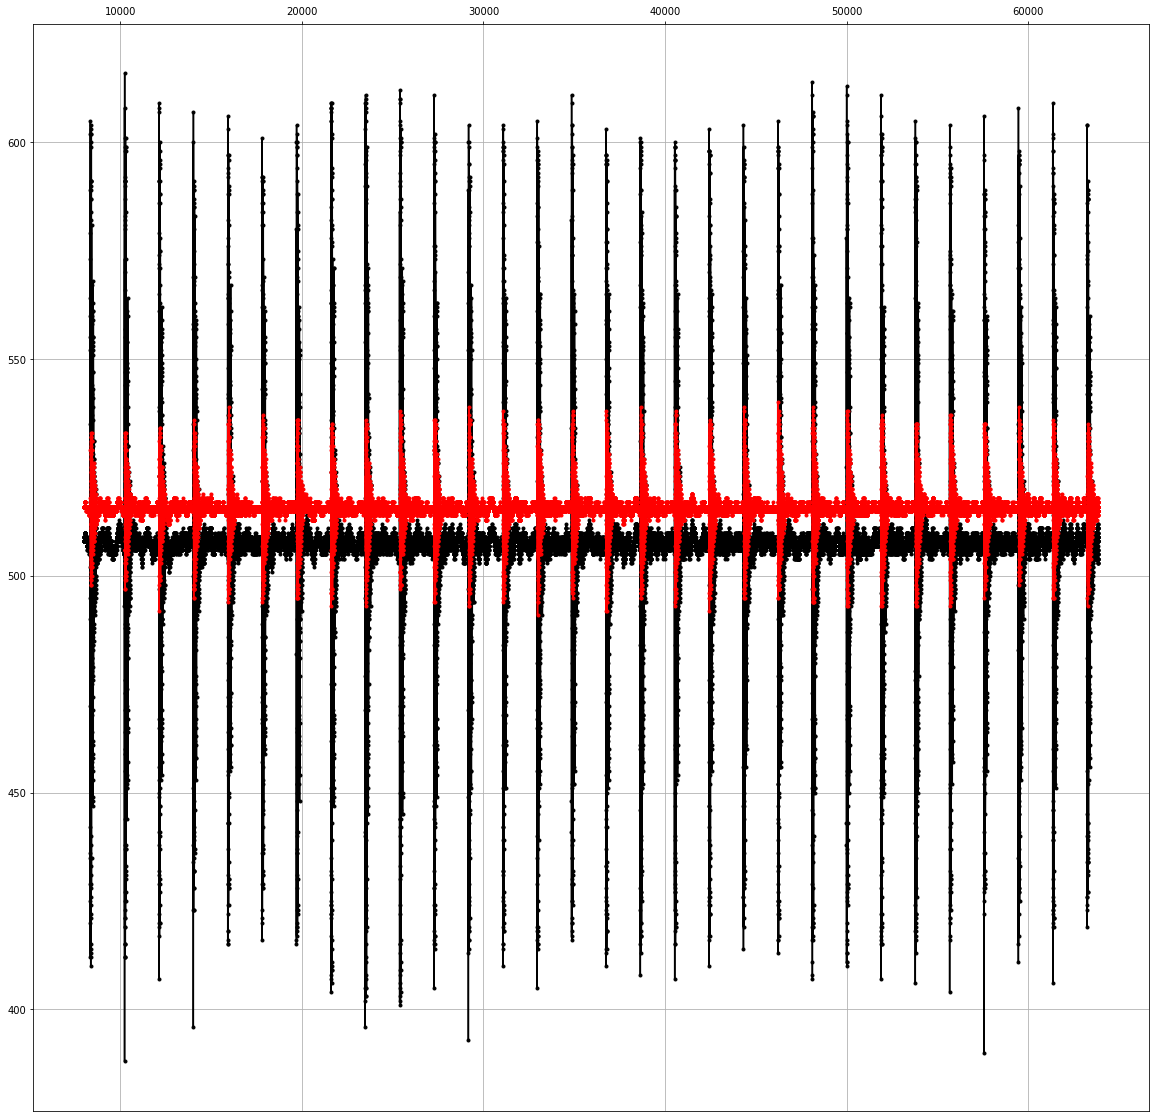

In [5]:
ax = plt.gca()
ax.xaxis.tick_top()
ax.plot(df.index, df["sensor1"], "k.-")
ax.plot(df.index, df["sensor2"], "r.-")
ax.grid()
fig = plt.gcf()
fig.set_size_inches(20, 20)
#x lim
a=4000
b=5000
#plt.xlim(0, 2000)

In [6]:
#import k-means
from sklearn.cluster import KMeans
df = df.reset_index().rename(columns={"index": "time"})

In [7]:
#identify 20 groups in df_sensor1 by k-means taking time and values into account
kmeans_sensor1 = KMeans(n_clusters=pulses_number, random_state=0).fit(df[["time", "sensor1"]])
kmeans_sensor2 = KMeans(n_clusters=pulses_number, random_state=0).fit(df[["time", "sensor2"]])

#write the clasification for each row in df_sensor1
df["sensor1_pulse"]=kmeans_sensor1.labels_
df["sensor2_pulse"]=kmeans_sensor2.labels_

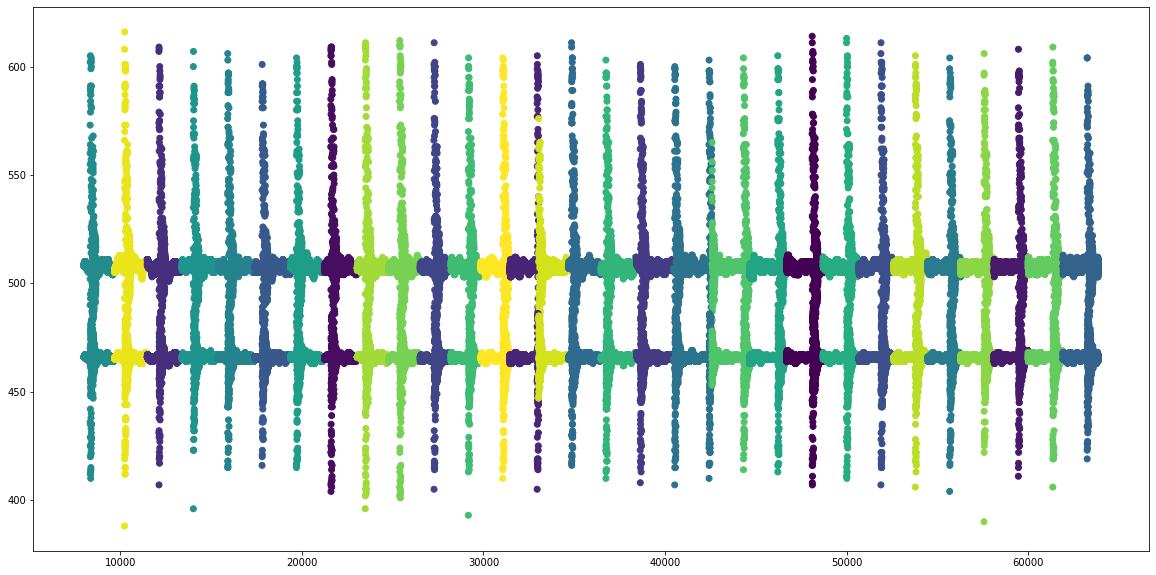

In [8]:
#plot the clasification
plt.figure(figsize=(20, 10))
plt.scatter(df["time"], df["sensor1"], c=df["sensor1_pulse"])
plt.scatter(df["time"], df["sensor2"] - 50, c=df["sensor2_pulse"])
plt.show()


In [9]:
#identify the time of the peak for each group
peaks1 = df[["sensor1", "sensor1_pulse"]].groupby("sensor1_pulse").idxmax().reset_index().rename(columns={"sensor1_pulse": "pulse"})

for pulse in peaks1["pulse"]:
    pulse_df = df.query(f"sensor1_pulse == {pulse}")
    #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
    if abs(pulse_df["sensor1"].max()) < pulse_df["sensor1"].mean() + 5*pulse_df["sensor1"].std():
        peaks1 = peaks1.query(f"pulse != {pulse}")

peaks2 = df[["sensor2", "sensor2_pulse"]].groupby("sensor2_pulse").idxmax().reset_index().rename(columns={"sensor2_pulse": "pulse"})

for pulse in peaks2["pulse"]:
    pulse_df = df.query(f"sensor2_pulse == {pulse}")
    #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
    if abs(pulse_df["sensor2"].max()) < pulse_df["sensor2"].mean() + 5*pulse_df["sensor2"].std():
        peaks2 = peaks2.query(f"pulse != {pulse}")


In [10]:
peaks = pd.merge(peaks1, peaks2, on="pulse")

In [11]:
peaks

,pulse,sensor1,sensor2
0,0,40104,40161
1,1,13617,13649
2,2,51463,51482
3,3,24965,24996
4,4,4135,4165
5,5,30646,30657
6,6,19287,19296
7,7,43895,43932
8,8,9815,9842
9,9,55247,55278


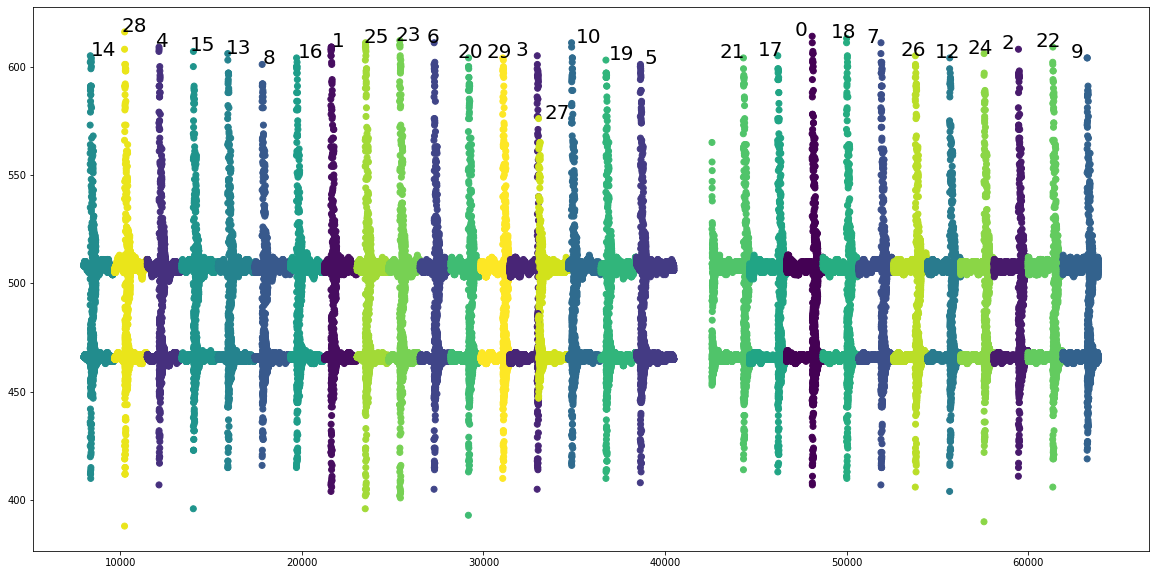

In [17]:
#plot the clasification
df_filtered = df.query("sensor1_pulse in @peaks.pulse and sensor2_pulse in @peaks.pulse")
plt.figure(figsize=(20, 10))
plt.scatter(df_filtered["time"], df_filtered["sensor1"], c=df_filtered["sensor1_pulse"])
plt.scatter(df_filtered["time"], df_filtered["sensor2"] - 50, c=df_filtered["sensor2_pulse"])

#put text over each pulse at the top of the pulse
for peak in peaks["pulse"]:
    peak_df = df_filtered.query(f"sensor1_pulse == {peak}")
    plt.text(peak_df["time"].mean()-peak_df["time"].std(), peak_df["sensor1"].max(), f"{peak}", fontsize=20)
#plt.xlim(4000, 5000)
plt.show()

In [18]:
#drop the pulse 27 in df_filtered
df_filtered = df_filtered.query("sensor1_pulse != 27 and sensor2_pulse != 27")

In [19]:
df_filtered = df_filtered[["time", "sensor1", "sensor2"]]

In [20]:
df_filtered

,time,sensor1,sensor2
0,8000,508.0,516.0
1,8001,508.0,516.0
2,8002,508.0,516.0
3,8003,509.0,516.0
4,8004,508.0,516.0
...,...,...,...
55866,63866,508.0,515.0
55867,63867,508.0,516.0
55868,63868,509.0,515.0
55869,63869,506.0,516.0


In [21]:
n_pulses_reclasified = len(peaks["pulse"])
kmeans_sensor1 = KMeans(n_clusters=n_pulses_reclasified, random_state=0).fit(df_filtered[["time", "sensor1"]])
kmeans_sensor2 = KMeans(n_clusters=n_pulses_reclasified, random_state=0).fit(df_filtered[["time", "sensor2"]])

#write the clasification for each row in df_sensor1
df_filtered["sensor1_pulse"]=kmeans_sensor1.labels_
df_filtered["sensor2_pulse"]=kmeans_sensor2.labels_

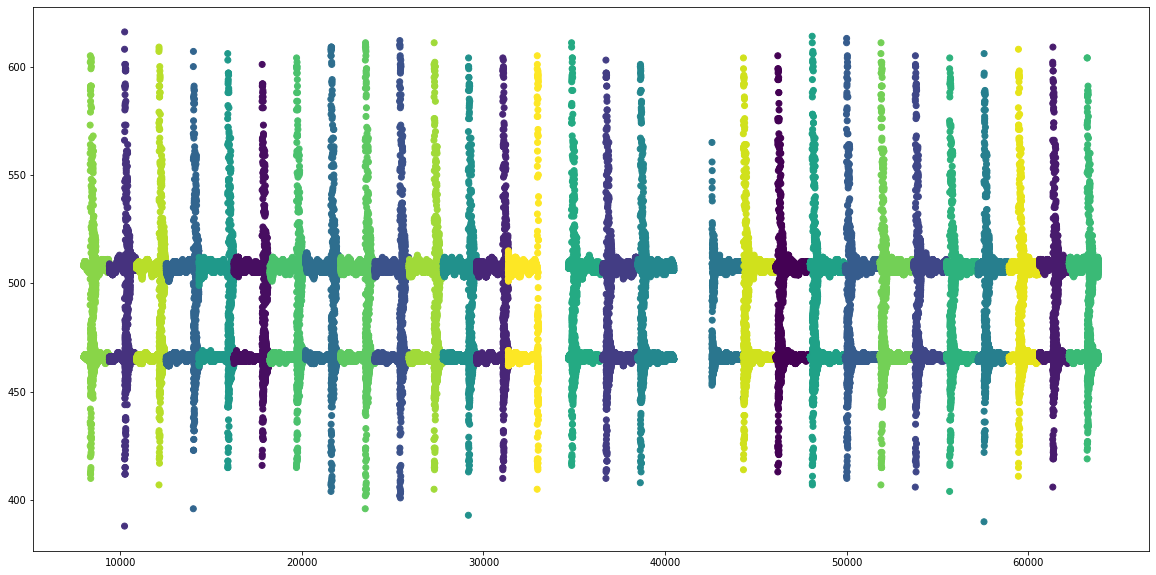

In [22]:
#plot the clasification
plt.figure(figsize=(20, 10))
plt.scatter(df_filtered["time"], df_filtered["sensor1"], c=df_filtered["sensor1_pulse"])
plt.scatter(df_filtered["time"], df_filtered["sensor2"] - 50, c=df_filtered["sensor2_pulse"])
#plt.xlim(4000, 5000)
plt.show()


In [23]:
#identify the time of the peak for each group
peaks1_filtered = df_filtered[["sensor1", "sensor1_pulse"]].groupby("sensor1_pulse").idxmax().reset_index().rename(columns={"sensor1_pulse": "pulse"})

for pulse in peaks1_filtered["pulse"]:
    pulse_df = df_filtered.query(f"sensor1_pulse == {pulse}")
    #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
    if abs(pulse_df["sensor1"].max()) < pulse_df["sensor1"].mean() + 5*pulse_df["sensor1"].std():
        peaks1_filtered = peaks1_filtered.query(f"pulse != {pulse}")

peaks2_filtered = df_filtered[["sensor2", "sensor2_pulse"]].groupby("sensor2_pulse").idxmax().reset_index().rename(columns={"sensor2_pulse": "pulse"})

for pulse in peaks2_filtered["pulse"]:
    pulse_df = df_filtered.query(f"sensor2_pulse == {pulse}")
    #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
    if abs(pulse_df["sensor2"].max()) < pulse_df["sensor2"].mean() + 5*pulse_df["sensor2"].std():
        peaks2_filtered = peaks2_filtered.query(f"pulse != {pulse}")


In [24]:
peaks_filtered = pd.merge(peaks1_filtered, peaks2_filtered, on="pulse")

In [25]:
peaks_filtered

,pulse,sensor1,sensor2
0,0,38211,38231
1,1,9815,9842
2,2,53361,53375
3,3,23070,23091
4,4,2243,2256
5,5,28746,28764
6,6,45788,45800
7,7,17397,17404
8,8,42002,42039
9,9,6030,6045


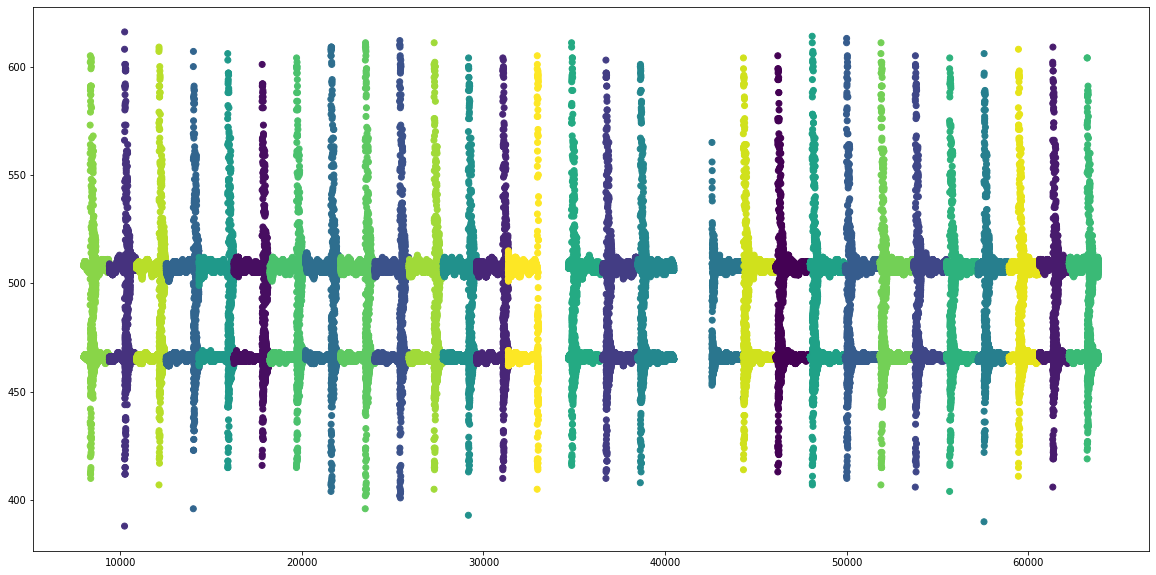

In [26]:
#plot the clasification
df_refiltered = df_filtered.query("sensor1_pulse in @peaks_filtered.pulse and sensor2_pulse in @peaks_filtered.pulse")
plt.figure(figsize=(20, 10))
plt.scatter(df_refiltered["time"], df_refiltered["sensor1"], c=df_refiltered["sensor1_pulse"])
plt.scatter(df_refiltered["time"], df_refiltered["sensor2"] - 50, c=df_refiltered["sensor2_pulse"])
#plt.xlim(4000, 5000)
plt.show()

In [27]:
abs(peaks_filtered["sensor1"] - peaks_filtered["sensor2"]).mean(), abs(peaks_filtered["sensor1"] - peaks_filtered["sensor2"]).std()

(24.96551724137931, 16.829996092480425)

In [28]:
time = abs(peaks_filtered["sensor1"] - peaks_filtered["sensor2"]).mean()*3/11369
speed = distance/time

In [29]:
speed

136.6164364640884